# DATA PRE-PROCESSING:

In [1]:
import gensim
gensim.__version__

'4.2.0'

In [2]:
# Root Path Modifier

google_colab = False

assets_root_path = 'drive/MyDrive/' if google_colab else '/Users/venkateshgunda/Documents/ASU_MSCS/CSE573_SWM/Group_Project/Code/'
dataset_root_path = f'{assets_root_path}Colab Datasets/20news-bydate/' if google_colab else f'{assets_root_path}Data/20news-bydate/'
model_root_path = f'{assets_root_path}Colab Models/CSE573_GroupProject_Doc2Vec/' if google_colab else f'{assets_root_path}Models/'
model_save_path = f'{model_root_path}model.bin'

In [3]:
if google_colab:
    from google.colab import drive
    drive.mount('/content/drive/')

In [ ]:
import nltk

nltk.download('all')

import os
import string
from nltk.stem import WordNetLemmatizer

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

print(ENGLISH_STOP_WORDS)

sw_nltk = stopwords.words('english')
print(sw_nltk)

wordnet_lemmatizer = WordNetLemmatizer()

def preprocess_textfile(filepath):
    # text reading
    tokens = []
    with open(filepath, 'r', encoding='utf8', errors='ignore') as f:
        text = f.read()
        # removal of stopwords
        # words = [word for word in text.split() if word.lower() not in sw_nltk]
        words = [word.lower() for word in text.split() if word.lower() not in ENGLISH_STOP_WORDS]
        new_text = " ".join(words)
        # print("Old length: ", len(text))
        # print("New length: ", len(new_text))
        # Removal of punctutaions
        tr_table = str.maketrans("", "", string.punctuation)
        s1 = new_text.translate(tr_table)
        # Tokenize the text
        tokenization = nltk.word_tokenize(s1)
        # lemmatize each token
        for w in tokenization:
            tokens.append(wordnet_lemmatizer.lemmatize(w).lower())
    # print(len(tokens))
    return tokens


rootdir = f'{dataset_root_path}20news-bydate-train/'
cleanedpath = f'{dataset_root_path}20news-bydate-train-processed/'

for dir in os.listdir(rootdir):
    dirpath = os.path.join(rootdir, dir)
    if os.path.isdir(dirpath):
        newdirpath = os.path.join(cleanedpath, dir)
        if not os.path.exists(newdirpath):
            os.makedirs(newdirpath)
        dirfile = open(newdirpath + "_file.json", 'w')
        tokendict = {}
        for file in os.listdir(dirpath):
            filepath = os.path.join(dirpath, file)
            # print(filepath)
            tokens = preprocess_textfile(filepath)
            newfilepath = os.path.join(newdirpath, file + "_cleaned")
            newfile = open(newfilepath, "w")
            newfile.write('\n'.join(tokens))
            tokendict[file] = tokens
            newfile.close
        dirfile.write(str(tokendict))
        dirfile.close()



DATASET LINK:
http://qwone.com/~jason/20Newsgroups/

Google Drive File Manager: https://towardsdatascience.com/how-to-manage-files-in-google-drive-with-python-d26471d91ecd

In [ ]:
# from pathlib import Path
# total_dir_files = len(list(Path('drive/MyDrive/Colab Datasets/20news-bydate/20news-bydate-train/').rglob('*')))
# total_dir_files

# IMPLEMENTATION NOTES:

Find out the best Embedding Methodology for Documents. Infer Doc2Vec code to get the embeddings for the whole Document. Also, explore the HuggingFace transformers Models for a Document Embedding Model. Basically, any BERT Sequence Transformer Model will work.

Use the existing k_means Clustering Libraries for PyTorch/Sklearn. The difference will be that our num_clusters will be only 2 in each iteration. Once an iteration is converged, then take the cluster with the maximum Intra-cluster variance and then further do the split by 2. Kep doing this until we reach the total number of clusters equal to 20.

PyTorch K-Means Library: https://pypi.org/project/kmeans-pytorch/



In [4]:
import os
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, BisectingKMeans
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [5]:
documents = {}
document_keys = set()
topic_list = []
topic_dict = {}
train_files_directory = f'{dataset_root_path}20news-bydate-train-processed/'
# The Processed Documents Count is lower, because of Errors.

document_embedding_vector_size = 512

In [6]:
for topic_dir in os.listdir(train_files_directory):
  curr_dir = train_files_directory+topic_dir
  if os.path.isdir(curr_dir):
    topic_list.append(topic_dir)
    for file in os.listdir(curr_dir):
      unique_file_key = f'{topic_dir}.{file}'
      document_keys.add(unique_file_key)
      with open(f'{curr_dir}/{file}',mode='r', encoding='utf-8',errors='ignore') as file_content:
        documents[unique_file_key] = file_content.read().split('\n')
print(len(documents))
topic_dict = {topic:i for i,topic in enumerate(topic_list)}

11314


In [7]:
tagged_documents = [TaggedDocument(documents[key],[key]) for key in documents.keys()]

In [8]:
tagged_documents[0]

TaggedDocument(words=['from', 'bf3833pyuxeccbellcorecom', 'feigenbaumbenjamin', 'subject', 're', 'israel', 'expansion', 'ii', 'organization', 'bellcore', 'livingston', 'nj', 'summary', 'hope', 'spring', 'eternal', 'line', '37', 'article', '1993apr2001303720907newscolumbiaedu', 'pgf5cunixbcccolumbiaedu', 'peter', 'garfiel', 'freeman', 'writes', 'article', '19apr93223044620062vm1mcgillca', 'b8hamusicbmcgillca', 'b8ha', 'writes', 'so', 'nice', 'answer', 'question', 'nice', 'of', 'feel', 'heart', 'palestinian', 'some', 'land', 'focus', 'fact', 'israel', 'annexed', 'this', 'land', 'kind', 'gesture', 'back', 'well', 'i', 'hope', 'state', 'run', 'palestinian', 'established', 'the', 'decision', 'make', 'jerusalem', 'state', 'by', 'annexing', 'course', 'steve', 'steve', 'israeli', 'stupid', 'allow', 'second', 'palestinian', 'state', 'the', 'jordon', 'probably', 'wish', 'israeli', 'whats', 'coming', 'them', 'however', 'palestinian', 'demonstrate', 'govern', 'live', 'peace', 'jewish', 'neighbor',

In [52]:
doc2vec_model = Doc2Vec(tagged_documents, vector_size=document_embedding_vector_size, workers=(2 if google_colab else 8), epochs=500) # Colab CPU has 2 Cores

KeyboardInterrupt: 

In [ ]:
document_vectors = {}
for document_key in document_keys:
  document_vectors[document_key] = doc2vec_model.docvecs[document_key]

temp_items = list(document_keys)[:10]
print(temp_items[0])
print(document_vectors[temp_items[0]])

In [ ]:
model_vector = doc2vec_model.infer_vector(['hello', 'world', 'everyone'])

In [ ]:
doc2vec_model.save(model_save_path)
document_vectors_save_path = f'{model_root_path}document_vectors'
doc2vec_model.save_word2vec_format(document_vectors_save_path, doctag_vec=True)

In [ ]:
doc2vec_loaded_model = Doc2Vec.load(model_save_path)
loaded_model_vector = doc2vec_loaded_model.infer_vector(['hello','world', 'everyone'])
document_vectors = {}
for document_key in document_keys:
  document_vectors[document_key] = doc2vec_loaded_model.dv[document_key]

In [ ]:
print(np.sqrt(np.dot(model_vector, loaded_model_vector)))
print(np.sqrt(np.dot(model_vector/(np.linalg.norm(model_vector)), loaded_model_vector/(np.linalg.norm(loaded_model_vector)))))

# DOCUMENT CLUSTERING (HIERARCHICAL/BISECTING K-MEANS):

In [ ]:
document_vectors_list = list(document_vectors.items())

bisecting_kmeans_model = BisectingKMeans(n_clusters=20, init='k-means++',n_init=20, max_iter=200000, verbose=0).fit([doc_vec[1] for doc_vec in document_vectors_list])
# algorithm='elkan', bisecting_strategy='largest_cluster'

print('Non-normalized Vector Inertia:',bisecting_kmeans_model.inertia_)

# Normalize Input Data [RESULTS ARE NOT AS ACCURATE]
# normalized_document_vectors = {}
# for key in document_vectors.keys():
#   normalized_document_vectors[key] = document_vectors[key]/(np.linalg.norm(document_vectors[key]))
# bisecting_kmeans_model_normalized = BisectingKMeans(n_clusters=20, init='k-means++',n_init=20, max_iter=30000, verbose=0).fit(list(normalized_document_vectors.values()))

# print('Normalized Vector Inertia:',bisecting_kmeans_model_normalized.inertia_)

In [ ]:
# Divide Documents into their respective Clusters
document_clusters = {} # Document->Cluster Mapping
clustered_documents = [[] for j in range(20)] # Cluster->[Documents] List

for doc_id, label in zip([doc_vec[0] for doc_vec in document_vectors_list], bisecting_kmeans_model.labels_):
    document_clusters[doc_id] = label
    clustered_documents[label].append(doc_id)

In [ ]:
# document_clusters['talk.politics.misc.178314_cleaned']
for i in range(20):
    print(f'Cluster {i} has {len(clustered_documents[i])} Documents')
clustered_documents[1][:10]

In [ ]:
import shutil

train_raw_data_path = f'{dataset_root_path}20news-bydate-train/'
clustered_data_save_path = f'{dataset_root_path}20news-bydate-train-clustered/'
if not os.path.exists(clustered_data_save_path):
    os.makedirs(clustered_data_save_path)
num_clusters = 20
for i in range(num_clusters):
    clustered_file_directory_path = f'{clustered_data_save_path}cluster_{i+1}/'
    if not os.path.exists(clustered_file_directory_path):
        os.makedirs(clustered_file_directory_path)
    else:
        shutil.rmtree(clustered_file_directory_path)
        os.makedirs(clustered_file_directory_path)
    for file in clustered_documents[i]:
        file_split = file.rsplit('.',1)
        file_name = file_split[1].removesuffix('_cleaned')
        original_file_path = f'{train_raw_data_path}{file_split[0]}/{file_name}'
        clustered_file_path = f'{clustered_file_directory_path}{file_name}'
        shutil.copy2(original_file_path,clustered_file_path)
    print(f'Copied All Files for Cluster {i+1}')

# [EXPERIMENTAL SECTION] HIERARCHICAL K-MEANS CUSTOM ALGORITHM

In [ ]:
# Re-write this as a Class and internal Functions
def hierarchical_k_means_clustering(input_data, num_clusters=20):
  from sklearn.cluster import KMeans
  import heapq
  import numpy as np
  def distance_between(vector_1, vector_2): # Eucledian Distance
    return np.sqrt(abs(np.dot(vector_1, vector_2)))
  def bisect_data(input_data):
    kmeans_output = KMeans(n_clusters=2, n_init=20, tol=1e-20, verbose=0).fit(input_data)
    # print(kmeans_output.cluster_centers_)
    return kmeans_output.cluster_centers_
  def best_cluster(cluster_centroids, input_data_point):
    return 0 if (distance_between(cluster_centroids[0], input_data_point)-distance_between(cluster_centroids[1], input_data_point))<0 else 1
  def divide_input_data_by_clusters(cluster_centroids, input_data):
    cluster_wise_input_data = [[],[]] # [[]*len(cluster_centroids)]
    for input_data_point in input_data:
      cluster_wise_input_data[best_cluster(cluster_centroids,input_data_point)].append(input_data_point)
    return cluster_wise_input_data
  def compute_intra_cluster_variance(cluster_centroid, cluster_input_data):
    intra_cluster_variance = 0
    for cluster_input_data_point in cluster_input_data:
      intra_cluster_variance += distance_between(cluster_centroid, cluster_input_data_point)
    return intra_cluster_variance
  # Main Control Loop
  optimal_clusters = [(0, np.random.rand(), (np.random.rand(document_embedding_vector_size), input_data))] # The original Dataset needs to get picked up the first time
  while len(optimal_clusters)<num_clusters:
    max_variance_cluster = heapq.heappop(optimal_clusters)
    print(f'Maximum Cluster Variance: {-max_variance_cluster[0]}')
    cluster_centroids = bisect_data(max_variance_cluster[2][1])
    clustered_input_data = divide_input_data_by_clusters(cluster_centroids, max_variance_cluster[2][1])
    cluster_1_variance = compute_intra_cluster_variance(cluster_centroids[0],clustered_input_data[0])
    cluster_2_variance = compute_intra_cluster_variance(cluster_centroids[1],clustered_input_data[1])
    print(len(clustered_input_data[0]),len(clustered_input_data[1]))
    print(cluster_1_variance,cluster_2_variance)
    heapq.heappush(optimal_clusters,(-cluster_1_variance,np.random.rand(),(cluster_centroids[0],clustered_input_data[0])))
    heapq.heappush(optimal_clusters,(-cluster_2_variance,np.random.rand(),(cluster_centroids[1],clustered_input_data[1])))
  return optimal_clusters

In [ ]:
# Normalize Input Data 
# normalized_document_vectors = {}
# for key in document_vectors.keys():
#   normalized_document_vectors[key] = document_vectors[key]/(np.linalg.norm(document_vectors[key]))
# bisecting_k_means_clusters = hierarchical_k_means_clustering(list(normalized_document_vectors.values()))

# bisecting_k_means_clusters = hierarchical_k_means_clustering(list(document_vectors.values()))

# from sklearn.cluster import KMeans
# k_means_model = KMeans(n_clusters=1000).fit(list(document_vectors.values()))

# DATA VISUALIZATION:

In [ ]:
# ELBOW METHOD TO FIND THE OPTIMAL NUMBER OF CLUSTERS

document_vectors = {}
for document_key in document_keys:
  document_vectors[document_key] = doc2vec_loaded_model.dv[document_key]

# temp_items = list(document_keys)[:10]
# print(temp_items[0])
# print(document_vectors[temp_items[0]])

ssd = []
input_dt = list(document_vectors.values())
for num_clusters in list(range(1,100)):
    model_clus = KMeans(n_clusters = num_clusters,random_state= 50)
    model_clus.fit(input_dt)
    print(num_clusters, ': ', model_clus.inertia_)
    ssd.append(model_clus.inertia_)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(ssd)
plt.title('ELBOW to identify Ideal Cluster Size')

In [17]:
from sklearn.manifold import TSNE

In [10]:
# Works decently well for 32 vector size, but testing for 50->64 if the results will be better.
tagged_documents = [TaggedDocument(documents[key],[key]) for key in documents.keys()]
tsne_doc2vec_model = Doc2Vec(tagged_documents, vector_size=64, workers=(2 if google_colab else 8), epochs=500) # Colab CPU has 2 Cores

tsne_visualization_model_save_path = f'{model_root_path}tsne_viz_model.bin'
tsne_doc2vec_model.save(tsne_visualization_model_save_path)

document_vectors = {}
for document_key in document_keys:
  document_vectors[document_key] = tsne_doc2vec_model.dv[document_key]

In [11]:
tsne_visualization_model_save_path = f'{model_root_path}tsne_viz_model.bin'
tsne_doc2vec_model = Doc2Vec.load(tsne_visualization_model_save_path)

In [12]:
input_dt = []
document_train_label = []

document_vectors_save_path = f'{model_root_path}document_vectors'
# document_vectors = Doc2Vec.load_word2vec_format(document_vectors_save_path)

# ADD CLASS LABEL NUMBERS
# for dv_key, dv_value in document_vectors.items():
# #     if topic_dict[dv_key.rsplit('.',1)[0]]<15:
# #         document_train_label.append(topic_dict[dv_key.rsplit('.',1)[0]])
# #         input_dt.append(dv_value)
#     document_train_label.append(topic_dict[dv_key.rsplit('.',1)[0]])
#     input_dt.append(dv_value)

# ADD CLASS LABEL NAME
for dv_key, dv_value in document_vectors.items():
#     if topic_dict[dv_key.rsplit('.',1)[0]]<15:
#         document_train_label.append(topic_dict[dv_key.rsplit('.',1)[0]])
#         input_dt.append(dv_value)
    document_train_label.append(dv_key.rsplit('.',1)[0])
    input_dt.append(dv_value)

In [129]:
# 2-Dimensional tSNE Visualization

tsne_model_2d_5000_20 = TSNE(n_components=2, n_jobs=-1, n_iter=5000, perplexity=20) # , n_iter=5000
tsne_fit_2d_5000_20 = tsne_model_2d_5000_20.fit_transform(np.asarray(input_dt))

# Save Results
tsne_fit_2d_5000_20_results_path = f'{assets_root_path}Results/tsne_fit_2d_5000_20.npy'
np.save(tsne_fit_2d_5000_20_results_path,tsne_fit_2d_5000_20)

/Users/venkateshgunda/opt/anaconda3/envs/cse573-nlp/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/venkateshgunda/opt/anaconda3/envs/cse573-nlp/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [130]:
# Load and Use Results
tsne_fit_2d_5000_20 = np.load(tsne_fit_2d_5000_20_results_path)

(11314, 2)


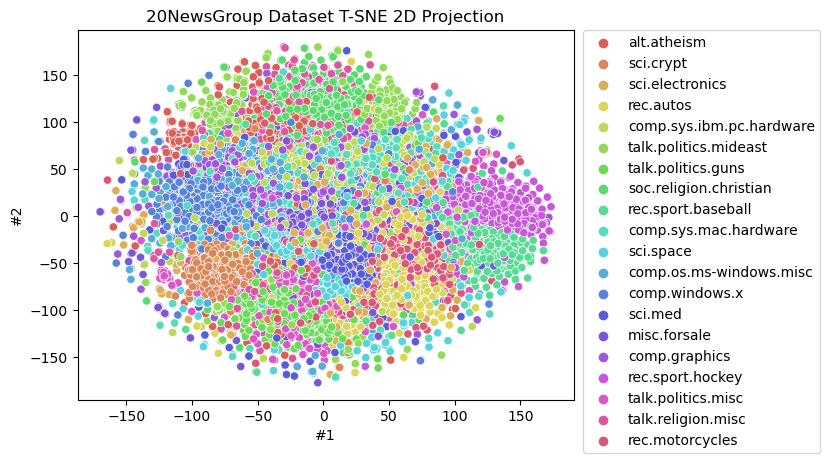

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns

tsne_fit = tsne_fit_2d_5000_20

tsne_data = pd.DataFrame()
tsne_data["y"] = document_train_label
tsne_data["#1"] = tsne_fit[:,0]
tsne_data["#2"] = tsne_fit[:,1]

sns.scatterplot(x="#1", y="#2", hue=tsne_data.y.tolist(), palette=sns.color_palette("hls",20),data=tsne_data).set(title="20NewsGroup Dataset T-SNE 2D Projection")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [132]:
# Same plot as above, but increasing the perplexity

tsne_model_2d_5000_50 = TSNE(n_components=2, n_jobs=-1, n_iter=5000, perplexity=50) # , n_iter=5000
tsne_fit_2d_5000_50 = tsne_model_2d_5000_50.fit_transform(np.asarray(input_dt))

# Save Results
tsne_fit_2d_5000_50_results_path = f'{assets_root_path}Results/tsne_fit_2d_5000_50.npy'
np.save(tsne_fit_2d_5000_50_results_path,tsne_fit_2d_5000_50)

/Users/venkateshgunda/opt/anaconda3/envs/cse573-nlp/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/venkateshgunda/opt/anaconda3/envs/cse573-nlp/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [133]:
# Load and Use Results
tsne_fit_2d_5000_50 = np.load(tsne_fit_2d_5000_50_results_path)

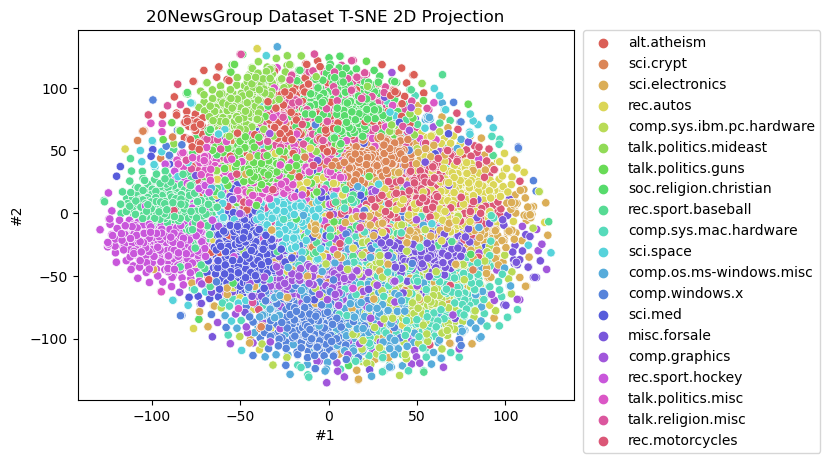

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns

tsne_fit = tsne_fit_2d_5000_50

tsne_data = pd.DataFrame()
tsne_data["y"] = document_train_label
tsne_data["#1"] = tsne_fit[:,0]
tsne_data["#2"] = tsne_fit[:,1]

sns.scatterplot(x="#1", y="#2", hue=tsne_data.y.tolist(), palette=sns.color_palette("hls",20),data=tsne_data).set(title="20NewsGroup Dataset T-SNE 2D Projection")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [135]:
# Same plot as above, but increasing the perplexity even more

tsne_model_2d_5000_100 = TSNE(n_components=2, n_jobs=-1, n_iter=5000, perplexity=100) # , n_iter=5000
tsne_fit_2d_5000_100 = tsne_model_2d_5000_100.fit_transform(np.asarray(input_dt))

# Save Results
tsne_fit_2d_5000_100_results_path = f'{assets_root_path}Results/tsne_fit_2d_5000_100.npy'
np.save(tsne_fit_2d_5000_100_results_path,tsne_fit_2d_5000_100)

/Users/venkateshgunda/opt/anaconda3/envs/cse573-nlp/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/venkateshgunda/opt/anaconda3/envs/cse573-nlp/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [136]:
# Load and Use Results
tsne_fit_2d_5000_100 = np.load(tsne_fit_2d_5000_100_results_path)

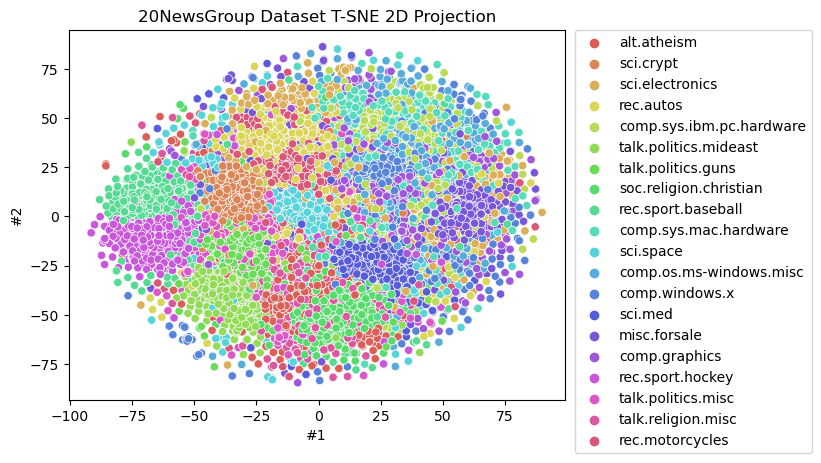

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns

tsne_fit = tsne_fit_2d_5000_100

tsne_data = pd.DataFrame()
tsne_data["y"] = document_train_label
tsne_data["#1"] = tsne_fit[:,0]
tsne_data["#2"] = tsne_fit[:,1]

sns.scatterplot(x="#1", y="#2", hue=tsne_data.y.tolist(), palette=sns.color_palette("hls",20),data=tsne_data).set(title="20NewsGroup Dataset T-SNE 2D Projection")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [138]:
# Same plot as above, but increasing the iterations

tsne_model_2d_10000_100 = TSNE(n_components=2, n_jobs=-1, n_iter=10000, perplexity=100) # , n_iter=5000
tsne_fit_2d_10000_100 = tsne_model_2d_10000_100.fit_transform(np.asarray(input_dt))

# Save Results
tsne_fit_2d_10000_100_results_path = f'{assets_root_path}Results/tsne_fit_2d_10000_100.npy'
np.save(tsne_fit_2d_10000_100_results_path,tsne_fit_2d_10000_100)

/Users/venkateshgunda/opt/anaconda3/envs/cse573-nlp/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/venkateshgunda/opt/anaconda3/envs/cse573-nlp/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [139]:
# Load and Use Results
tsne_fit_2d_10000_100 = np.load(tsne_fit_2d_10000_100_results_path)

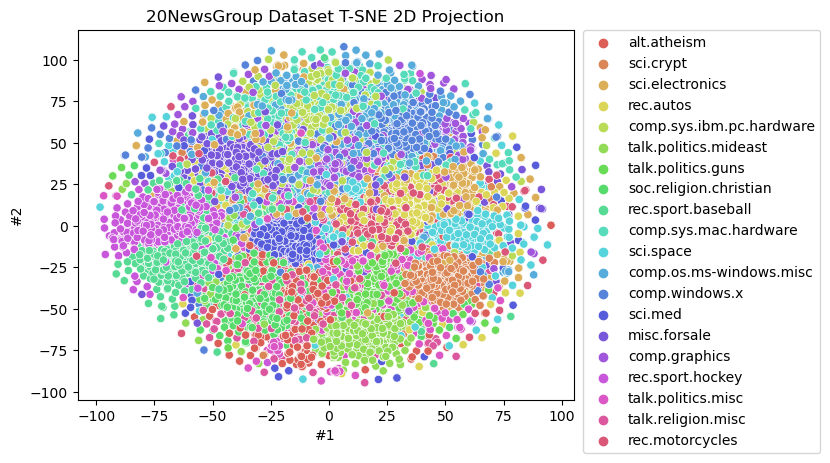

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns

tsne_fit = tsne_fit_2d_10000_100

tsne_data = pd.DataFrame()
tsne_data["y"] = document_train_label
tsne_data["#1"] = tsne_fit[:,0]
tsne_data["#2"] = tsne_fit[:,1]

sns.scatterplot(x="#1", y="#2", hue=tsne_data.y.tolist(), palette=sns.color_palette("hls",20),data=tsne_data).set(title="20NewsGroup Dataset T-SNE 2D Projection")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [141]:
# Same plot as above, but increasing the perplexity even more

tsne_model_2d_10000_200 = TSNE(n_components=2, n_jobs=-1, n_iter=10000, perplexity=200)
tsne_fit_2d_10000_200 = tsne_model_2d_10000_200.fit_transform(np.asarray(input_dt))

# Save Results
tsne_fit_2d_10000_200_results_path = f'{assets_root_path}Results/tsne_fit_2d_10000_200.npy'
np.save(tsne_fit_2d_10000_200_results_path,tsne_fit_2d_10000_200)

/Users/venkateshgunda/opt/anaconda3/envs/cse573-nlp/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/venkateshgunda/opt/anaconda3/envs/cse573-nlp/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [142]:
# Load and Use Results
tsne_fit_2d_10000_200 = np.load(tsne_fit_2d_10000_200_results_path)

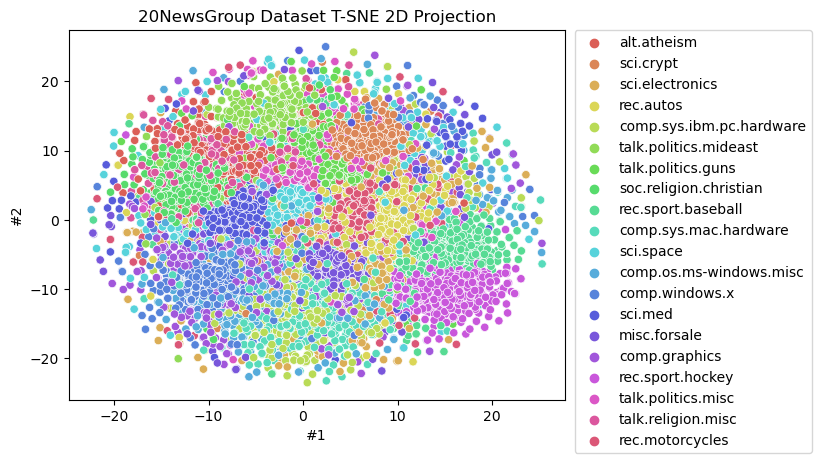

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns

tsne_fit = tsne_fit_2d_10000_200

tsne_data = pd.DataFrame()
tsne_data["y"] = document_train_label
tsne_data["#1"] = tsne_fit[:,0]
tsne_data["#2"] = tsne_fit[:,1]

sns.scatterplot(x="#1", y="#2", hue=tsne_data.y.tolist(), palette=sns.color_palette("hls",20),data=tsne_data).set(title="20NewsGroup Dataset T-SNE 2D Projection")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [ ]:
# 3-Dimensional Interactive tSNE Visualization

tsne_model_3d_5000_20 = TSNE(n_components=3, n_jobs=-1, n_iter=5000, perplexity=20) # , n_iter=5000
tsne_fit_3d_5000_20 = tsne_model_3d_5000_20.fit_transform(np.asarray(input_dt))

# Save Results
tsne_fit_3d_5000_20_results_path = f'{assets_root_path}Results/tsne_fit_3d_5000_20.npy'
np.save(tsne_fit_3d_5000_20_results_path,tsne_fit_3d_5000_20)

In [ ]:
# Load and Use Results
tsne_fit_3d_5000_20_results_path = f'{assets_root_path}Results/tsne_fit_3d_5000_20.npy'
tsne_fit_3d_5000_20 = np.load(tsne_fit_3d_5000_20_results_path)

In [ ]:
import plotly.express as px

tsne_fit = tsne_fit_3d_5000_20

tsne_data = pd.DataFrame()
tsne_data["y"] = document_train_label
tsne_data["#1"] = tsne_fit[:,0]
tsne_data["#2"] = tsne_fit[:,1]
tsne_data["#3"] = tsne_fit[:,2]

figure = px.scatter_3d(tsne_data, x='#1', y='#2', z='#3', color='y')
figure.show()

In [ ]:
# Same plot as above, but with large perplexity

tsne_model_3d_5000_50 = TSNE(n_components=3, n_jobs=-1, n_iter=5000, perplexity=50) # , n_iter=5000
tsne_fit_3d_5000_50 = tsne_model_3d_5000_50.fit_transform(np.asarray(input_dt))

# Save Results
tsne_fit_3d_5000_50_results_path = f'{assets_root_path}Results/tsne_fit_3d_5000_50.npy'
np.save(tsne_fit_3d_5000_50_results_path,tsne_fit_3d_5000_50)

In [ ]:
# Load and Use Results
tsne_fit_3d_5000_50 = np.load(tsne_fit_3d_5000_50_results_path)

In [ ]:
import plotly.express as px

tsne_fit = tsne_fit_3d_5000_50

tsne_data = pd.DataFrame()
tsne_data["y"] = document_train_label
tsne_data["#1"] = tsne_fit[:,0]
tsne_data["#2"] = tsne_fit[:,1]
tsne_data["#3"] = tsne_fit[:,2]

figure = px.scatter_3d(tsne_data, x='#1', y='#2', z='#3', color='y')
figure.show()

In [ ]:
# Same plot as above, but with even larger perplexity

tsne_model_3d_5000_100 = TSNE(n_components=3, n_jobs=-1, n_iter=5000, perplexity=100) # , n_iter=5000
tsne_fit_3d_5000_100 = tsne_model_3d_5000_100.fit_transform(np.asarray(input_dt))

# Save Results
tsne_fit_3d_5000_100_results_path = f'{assets_root_path}Results/tsne_fit_3d_5000_100.npy'
np.save(tsne_fit_3d_5000_100_results_path,tsne_fit_3d_5000_100)

In [ ]:
# Load and Use Results
tsne_fit_3d_5000_100 = np.load(tsne_fit_3d_5000_100_results_path)

In [ ]:
import plotly.express as px

tsne_fit = tsne_fit_3d_5000_100

tsne_data = pd.DataFrame()
tsne_data["y"] = document_train_label
tsne_data["#1"] = tsne_fit[:,0]
tsne_data["#2"] = tsne_fit[:,1]
tsne_data["#3"] = tsne_fit[:,2]

figure = px.scatter_3d(tsne_data, x='#1', y='#2', z='#3', color='y')
figure.show()

In [ ]:
# Same plot as above, but with larger iterations

tsne_model_3d_10000_100 = TSNE(n_components=3, n_jobs=-1, n_iter=10000, perplexity=100) # , n_iter=5000
tsne_fit_3d_10000_100 = tsne_model_3d_10000_100.fit_transform(np.asarray(input_dt))

# Save Results
tsne_fit_3d_10000_100_results_path = f'{assets_root_path}Results/tsne_fit_3d_10000_100.npy'
np.save(tsne_fit_3d_10000_100_results_path,tsne_fit_3d_10000_100)

In [ ]:
# Load and Use Results
tsne_fit_3d_10000_100 = np.load(tsne_fit_3d_10000_100_results_path)

In [13]:
import plotly.express as px

tsne_fit = tsne_fit_3d_10000_100

tsne_data = pd.DataFrame()
tsne_data["y"] = document_train_label
tsne_data["#1"] = tsne_fit[:,0]
tsne_data["#2"] = tsne_fit[:,1]
tsne_data["#3"] = tsne_fit[:,2]

figure = px.scatter_3d(tsne_data, x='#1', y='#2', z='#3', color='y')
figure.show()

NameError: name 'tsne_fit_3d_10000_100' is not defined

In [18]:
# Same plot as above, but with even larger perplexity

tsne_model_3d_10000_200 = TSNE(n_components=3, n_jobs=-1, n_iter=10000, perplexity=200) # , n_iter=5000
tsne_fit_3d_10000_200 = tsne_model_3d_10000_200.fit_transform(np.asarray(input_dt))

# Save Results
tsne_fit_3d_10000_200_results_path = f'{assets_root_path}Results/tsne_fit_3d_10000_200.npy'
np.save(tsne_fit_3d_10000_200_results_path,tsne_fit_3d_10000_200)

/Users/venkateshgunda/opt/anaconda3/envs/cse573-nlp/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/venkateshgunda/opt/anaconda3/envs/cse573-nlp/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [19]:
# Load and Use Results
tsne_fit_3d_10000_200 = np.load(tsne_fit_3d_10000_200_results_path)

In [20]:
import plotly.express as px

tsne_fit = tsne_fit_3d_10000_200

tsne_data = pd.DataFrame()
tsne_data["y"] = document_train_label
tsne_data["#1"] = tsne_fit[:,0]
tsne_data["#2"] = tsne_fit[:,1]
tsne_data["#3"] = tsne_fit[:,2]

figure = px.scatter_3d(tsne_data, x='#1', y='#2', z='#3', color='y')

visualization_save_path = f'{assets_root_path}Results/tsne_fit_3d_10000_200_interactive_visualization.html'
figure.write_html(visualization_save_path)
figure.show()

In [ ]:
# WordCloud Visualization

# SOURCE: https://www.datacamp.com/tutorial/wordcloud-python
# SOURCE: https://github.com/amueller/word_cloud
from wordcloud import WordCloud

# DOCUMENT CLUSTERING EVALUATION:

In [ ]:
# IDENTIFY DOMINATING TOPIC IN CLUSTERS:

from gensim.models.doc2vec import Doc2Vec
doc2vec_loaded_model = Doc2Vec.load(model_save_path)

def get_dominating_topic(documents):
    document_topics = [document.rsplit('.',1)[0] for document in documents]
    return max(document_topics, key=document_topics.count)

document_cluster_dominating_topic = []
for i in range(len(clustered_documents)):
    document_cluster_dominating_topic.append(get_dominating_topic(clustered_documents[i]))
print('Dominating Topics:',document_cluster_dominating_topic)

In [ ]:
# ASSIGN ORIGINAL & PREDICTED CLUSTER TO ALL DOCUMENTS
document_label_predicted_dict_names = {}
document_label_predicted_dict_indices = [[],[]] # [ORIGINAL, PREDICTED]

for doc_id in documents.keys():
    document_label_predicted_dict_names[doc_id] = (doc_id.rsplit('.',1)[0], document_cluster_dominating_topic[document_clusters[doc_id]])
    document_label_predicted_dict_indices[0].append(topic_dict[doc_id.rsplit('.',1)[0]])
    document_label_predicted_dict_indices[1].append(topic_dict[document_cluster_dominating_topic[document_clusters[doc_id]]])

# PRINT FIRST 20 DOCUMENTS TO VALIDATE THE ASSIGNMENT
print('DOCUMENT->(ORIGINAL_TOPIC, PREDICTED_TOPIC)')
for doc in list(document_clusters.keys())[:20]:
    print(f'{doc}->{document_label_predicted_dict[doc]}')


In [ ]:
# PURITY SCORE:
# Assign Cluster Topic as the one the NewsGroup is the most frequent for the Cluster.
# That is considered as the y_pred for all the Documents in that Cluster.
# Using that and the y_original we have from the original folder structure, we can compute the purity.
import numpy as np
from sklearn import metrics
# SOURCE: https://stackoverflow.com/questions/34047540/python-clustering-purity-metric/51672699#51672699
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

# There is an alternative called Cluster Accuracy for when Number of Clusters are equal to Labels
import numpy as np
from sklearn import metrics
from scipy.optimize import linear_sum_assignment
# SOURCE: https://stackoverflow.com/questions/34047540/python-clustering-purity-metric
def cluster_accuracy(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # Find optimal one-to-one mapping between cluster labels and true labels
    row_ind, col_ind = linear_sum_assignment(-contingency_matrix)
    # Return cluster accuracy
    return contingency_matrix[row_ind, col_ind].sum() / np.sum(contingency_matrix)

for i in range(20):
    mod_predicted_data = [doc.rsplit('.',1)[0] for doc in clustered_documents[i]]
    print(f'DOMINATING TOPIC RATIO in CLUSTER {i+1}: {mod_predicted_data.count(document_cluster_dominating_topic[i])/len(mod_predicted_data)} ({document_cluster_dominating_topic[i]})')
print(f'OVERALL MODEL PURITY SCORE: {purity_score(document_label_predicted_dict_indices[0], document_label_predicted_dict_indices[1])}')

In [ ]:
# NORMALIZED MUTUAL INFORMATION (NMI):

# SOURCE: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html
from sklearn.metrics import normalized_mutual_info_score
print(f'OVERALL MODEL NMI SCORE: {normalized_mutual_info_score(document_label_predicted_dict_indices[0],document_label_predicted_dict_indices[1])}')

In [ ]:
# RAND INDEX:

# SOURCE: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.rand_score.html
from sklearn.metrics import rand_score
print(f'OVERALL MODEL RAND INDEX SCORE: {rand_score(document_label_predicted_dict_indices[0],document_label_predicted_dict_indices[1])}')

In [ ]:
# F-MEASURE:

# First, construct the Confusion Matrix for the Clustering. (y_true, y_pred)
# Second, compute the Precision and Recall for all the Clusters.
# Third, compute the F-Score (F1) with the regular formula => (2*P*R)/(P+R)